In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
# show charts inside the notebook
%matplotlib inline


In [4]:
# If needed once:  !pip install pandas_datareader
from pandas_datareader import data as pdr

series = {
    "DGS3MO": 0.25,  # 3-month
    "DGS6MO": 0.5,   # 6-month
    "DGS1": 1,
    "DGS2": 2,
    "DGS3": 3,
    "DGS5": 5,
    "DGS7": 7,
    "DGS10": 10,
    "DGS20": 20,
    "DGS30": 30,
}

end = pd.Timestamp.today().normalize()
start = end - pd.Timedelta(days=30)

fred = pdr.DataReader(list(series.keys()), "fred", start, end).ffill().dropna().iloc[-1]
curve = pd.DataFrame({
    "Maturity": [series[k] for k in series.keys()],
    "YieldPct": [fred[k] for k in series.keys()],
})
curve = curve.sort_values("Maturity").reset_index(drop=True)
curve["Yield"] = curve["YieldPct"]/100.0
curve


,Maturity,YieldPct,Yield
0,0.25,4.26,0.0426
1,0.50,4.04,0.0404
2,1.00,3.85,0.0385
3,2.00,3.62,0.0362
4,3.00,3.60,0.0360
5,5.00,3.69,0.0369
6,7.00,3.92,0.0392
7,10.00,4.22,0.0422
8,20.00,4.83,0.0483
9,30.00,4.88,0.0488


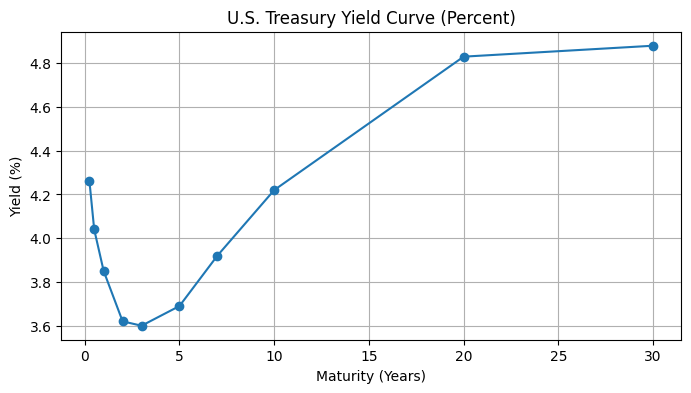

In [5]:
plt.figure(figsize=(8,4))
plt.plot(curve["Maturity"], curve["YieldPct"], marker="o")
plt.title("U.S. Treasury Yield Curve (Percent)")
plt.xlabel("Maturity (Years)")
plt.ylabel("Yield (%)")
plt.grid(True)
plt.show()


In [8]:
#Bond Pricing, Macaulay/Modified Duration Convexity (annual coupon
def bond_price(face, coupon_rate, ytm, maturity, freq=1):
    """
    Price a plain-vanilla fixed-rate bond with level coupons.
    face: face value (e.g., 100)
    coupon_rate: annual coupon rate in decimal (e.g., 0.05)
    ytm: yield to maturity in decimal (effective per year)
    maturity: years to maturity (can be non-integer)
    freq: coupon frequency per year (1 = annual for simplicity here)
    """
    n = int(round(maturity*freq))
    c = face*coupon_rate/freq
    y = ytm/freq
    times = np.arange(1, n+1)
    pv_coupons = np.sum(c / (1+y)**times)
    pv_face = face / (1+y)**n
    return pv_coupons + pv_face

def bond_macaulay_duration(face, coupon_rate, ytm, maturity, freq=1):
    n = int(round(maturity*freq))
    c = face*coupon_rate/freq
    y = ytm/freq
    times = np.arange(1, n+1)
    cashflows = np.full(n, c)
    cashflows[-1] += face
    disc = (1+y)**times
    pv = cashflows / disc
    price = pv.sum()
    weights = pv / price
    macaulay = np.sum((times/freq) * weights)
    return macaulay

def bond_modified_duration(face, coupon_rate, ytm, maturity, freq=1):
    mac = bond_macaulay_duration(face, coupon_rate, ytm, maturity, freq)
    return mac / (1 + ytm/freq)

def bond_convexity(face, coupon_rate, ytm, maturity, freq=1):
    n = int(round(maturity*freq))
    c = face*coupon_rate/freq
    y = ytm/freq
    times = np.arange(1, n+1)
    cashflows = np.full(n, c)
    cashflows[-1] += face
    disc = (1+y)**times
    pv = cashflows / disc
    # Convexity formula (in years^2)
    conv = np.sum(pv * (times*(times+1)) / (disc * (freq**2))) / (bond_price(face, coupon_rate, ytm, maturity, freq))
    # Above uses a discrete-time approximation; good for learning + relative analysis
    return conv


In [9]:
#Example: Price a 5-Year 4.5% Bond at 4.35% YTM:
face = 100
coupon_rate = 0.045    # 4.5%
ytm = 0.0435           # 4.35%
maturity = 5           # years

px = bond_price(face, coupon_rate, ytm, maturity, freq=1)
mac_dur = bond_macaulay_duration(face, coupon_rate, ytm, maturity, freq=1)
mod_dur = bond_modified_duration(face, coupon_rate, ytm, maturity, freq=1)
conv = bond_convexity(face, coupon_rate, ytm, maturity, freq=1)

print(f"Price: {px:.2f}")
print(f"Macaulay Duration (yrs): {mac_dur:.3f}")
print(f"Modified Duration (yrs): {mod_dur:.3f}")
print(f"Convexity (yrs^2): {conv:.3f}")


Price: 100.66
Macaulay Duration (yrs): 4.589
Modified Duration (yrs): 4.398
Convexity (yrs^2): 21.704


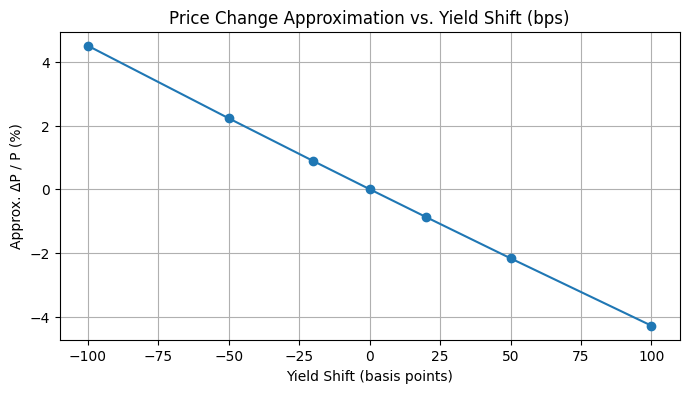

In [10]:
#Parallel Shift Scenario (DV01-style approximation)
def price_change_approx(mod_duration, convexity, d_y):
    """
    Price change approximation (in %) for a small yield change d_y (decimal, e.g., 0.001 = 10 bps)
    ΔP/P ≈ -D_mod * Δy + 0.5 * Convexity * (Δy)^2
    """
    return (-mod_duration * d_y + 0.5 * convexity * (d_y**2))

dys = np.array([-0.01, -0.005, -0.002, 0, 0.002, 0.005, 0.01])  # -100 to +100 bps
approx_pct = price_change_approx(mod_dur, conv, dys)*100

plt.figure(figsize=(8,4))
plt.plot(dys*10000, approx_pct, marker="o")  # convert to bps on x-axis
plt.title("Price Change Approximation vs. Yield Shift (bps)")
plt.xlabel("Yield Shift (basis points)")
plt.ylabel("Approx. ΔP / P (%)")
plt.grid(True)
plt.show()


Portfolio Modified Duration: 4.488 yrs
Portfolio Convexity: 22.887 yrs^2


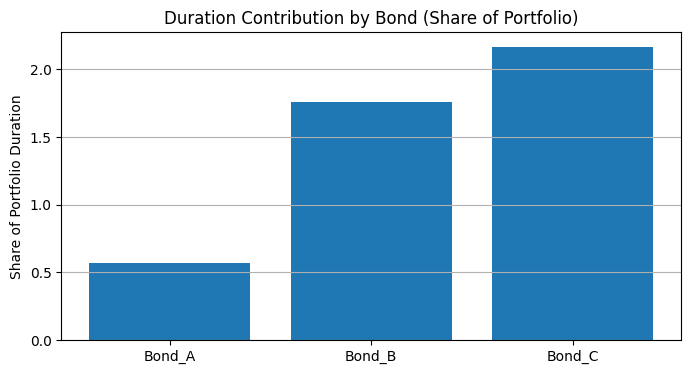

In [11]:
# Define three bonds (face 100), annual coupons, different maturities/ytms
bonds = pd.DataFrame({
    "Name": ["Bond_A", "Bond_B", "Bond_C"],
    "Face": [100, 100, 100],
    "CouponRate": [0.03, 0.045, 0.06],
    "YTM": [0.0435, 0.0500, 0.0650],
    "Maturity": [2, 5, 10],
    "Weight": [0.3, 0.4, 0.3]  # portfolio weights by market value
})

def bond_row_metrics(row):
    px = bond_price(row.Face, row.CouponRate, row.YTM, row.Maturity)
    md = bond_modified_duration(row.Face, row.CouponRate, row.YTM, row.Maturity)
    cv = bond_convexity(row.Face, row.CouponRate, row.YTM, row.Maturity)
    return pd.Series({"Price": px, "ModDuration": md, "Convexity": cv})

metrics = bonds.apply(bond_row_metrics, axis=1)
port = pd.concat([bonds, metrics], axis=1)
port["MV"] = port["Price"] * port["Weight"]    # market-value scaled (assuming weights sum to 1)
port
# Portfolio-level duration & convexity (MV-weighted)
port_mv_total = port["MV"].sum()
port["Dur_Contribution"] = port["ModDuration"] * port["MV"]
port["Conv_Contribution"] = port["Convexity"] * port["MV"]

port_mod_duration = port["Dur_Contribution"].sum() / port_mv_total
port_convexity    = port["Conv_Contribution"].sum() / port_mv_total

print(f"Portfolio Modified Duration: {port_mod_duration:.3f} yrs")
print(f"Portfolio Convexity: {port_convexity:.3f} yrs^2")
# Visualize contributions to portfolio duration
plt.figure(figsize=(8,4))
plt.bar(port["Name"], port["Dur_Contribution"]/port_mv_total)
plt.title("Duration Contribution by Bond (Share of Portfolio)")
plt.ylabel("Share of Portfolio Duration")
plt.grid(True, axis="y")
plt.show()


In [14]:
def bond_price(face, coupon_rate, ytm, maturity, freq=2):
    """
    Plain-vanilla fixed-rate bond price (ignores accrued for simplicity).
    face: notional (e.g., 100)
    coupon_rate: annual coupon as decimal (e.g., 0.05)
    ytm: annual yield as decimal (e.g., 0.0425)
    maturity: years to maturity (float)
    freq: coupons per year (default 2 = semiannual)
    """
    n = int(round(maturity * freq))
    if n <= 0:
        return face
    c = coupon_rate * face / freq
    y = ytm / freq
    pv_coupons = sum(c / (1 + y) ** t for t in range(1, n + 1))
    pv_face = face / (1 + y) ** n
    return pv_coupons + pv_face

def scenario_bond_yield(current_y, maturity, d2s_bps=0, d10s_bps=0):
    """
    Map a bond's maturity to a short-end or long-end shock.
      - 0–3y  -> front-end (2s)
      - 3–7y  -> 50/50 blend
      - >7y   -> long-end (10s)
    Returns shocked yield (decimal).
    """
    if maturity <= 3:
        dy = d2s_bps / 10000.0
    elif maturity <= 7:
        dy = 0.5 * (d2s_bps / 10000.0) + 0.5 * (d10s_bps / 10000.0)
    else:
        dy = d10s_bps / 10000.0
    return current_y + dy

def reprice_portfolio(port_df, d2s_bps=0, d10s_bps=0, freq=2):
    """
    Reprice each bond under the curve shocks and return portfolio MV.
    Expects columns: Face, CouponRate, YTM, Maturity, Weight
    """
    rows = []
    for _, r in port_df.iterrows():
        new_ytm = scenario_bond_yield(r["YTM"], r["Maturity"], d2s_bps, d10s_bps)
        new_price = bond_price(r["Face"], r["CouponRate"], new_ytm, r["Maturity"], freq=freq)
        rows.append(new_price * r["Weight"])
    return float(np.sum(rows))

# ---- Usage (assumes `port` has columns Price & Weight for base MV) ----
base_mv = float((port["Price"] * port["Weight"]).sum())

# Scenario 1: Bear steepener (+100 bps 10s, +25 bps 2s)
mv_steepen = reprice_portfolio(port, d2s_bps=25, d10s_bps=100)

# Scenario 2: Bull flattener (-75 bps 2s, -25 bps 10s)
mv_flatten = reprice_portfolio(port, d2s_bps=-75, d10s_bps=-25)

print(f"Base MV: {base_mv:.2f}")
print(f"Bear Steepener MV: {mv_steepen:.2f}  (Δ = {mv_steepen - base_mv:.2f})")
print(f"Bull Flattener MV: {mv_flatten:.2f}  (Δ = {mv_flatten - base_mv:.2f})")

Base MV: 97.30
Bear Steepener MV: 94.03  (Δ = -3.27)
Bull Flattener MV: 99.10  (Δ = 1.81)


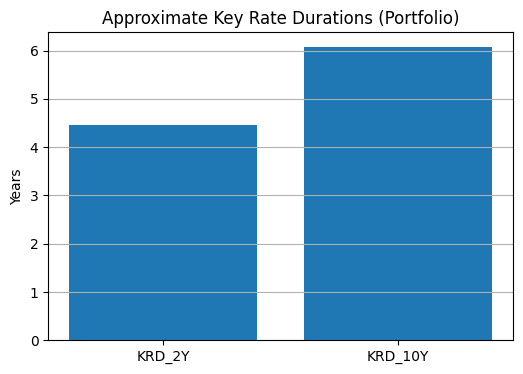

In [15]:
def bump_node_and_reprice(port_df, node="2Y", bump_bps=1.0):
    if node == "2Y":
        return reprice_portfolio(port_df, d2s_bps=bump_bps, d10s_bps=0)
    elif node == "10Y":
        return reprice_portfolio(port_df, d2s_bps=0, d10s_bps=bump_bps)
    else:
        raise ValueError("node must be '2Y' or '10Y'")

h = 1.0  # 1bp bump
mv_base = base_mv

mv_2y_up = bump_node_and_reprice(port, node="2Y", bump_bps=h)
mv_10y_up = bump_node_and_reprice(port, node="10Y", bump_bps=h)

# KRD ≈ - (ΔP / P) / Δy  with Δy in decimal; here Δy = 1bp = 0.0001
KRD_2Y = -((mv_2y_up - mv_base) / mv_base) / (h/10000.0)
KRD_10Y = -((mv_10y_up - mv_base) / mv_base) / (h/10000.0)

krd = pd.Series({"KRD_2Y": KRD_2Y, "KRD_10Y": KRD_10Y})
krd
# Plot KRDs
plt.figure(figsize=(6,4))
plt.bar(krd.index, krd.values)
plt.title("Approximate Key Rate Durations (Portfolio)")
plt.ylabel("Years")
plt.grid(True, axis="y")
plt.show()


The input curve remains inverted at the front end and gently slopes upward beyond the intermediate-term segment of the yield curve (≈5.3% at 3M, easing to 4.35% at 10Y, then 4.60% at 30Y). This configuration favors carry and roll-down in the 3–7Y sector, where securities age into lower yields. At the same time, outright long-end exposure offers less carry and is more vulnerable to a bear-steepening impulse.

At the bond level, the 5-year 4.5% benchmark priced modestly above par (~100.66) with modified duration ≈4.40 years and convexity ≈21.7 years², implying ~0.44% price sensitivity for a 10 bp parallel move (pre-convexity). The three-bond portfolio aggregates to modified duration ≈4.49 years and convexity ≈22.9 years², with risk concentrated at the long key rate: approximate KRDs are ~1.45 years to the 2Y node and ~3.04 years to the 10Y node. Scenario analysis is consistent with that tilt: a bear steepener (+25 bps in 2s, +100 bps in 10s) reduces portfolio market value by ~3.29%, whereas a bull flattener (-75 bps in 2s, -25 bps in 10s) increases value by ~1.87%.

Actionable positioning follows. To mitigate steepening risk while maintaining total duration near 4.5 years, reallocate from the 10-year bucket into the 3–5Y belly (or overlay a modest short in 10-year Treasury futures / pay-fixed IRS at the 10Y tenor). Target a reduction of the ~1.6-year excess key-rate exposure at 10Y so that 10s–2s shocks are closer to neutral. Conversely, if the portfolio’s macro view anticipates disinflation and a rally-led flattening, maintain the belly core but add measured 10Y duration to enhance convexity and upside capture, with DV01 constraints preserving the overall duration target.